<a href="https://colab.research.google.com/github/rahiakela/pytorch-computer-vision-cookbook/blob/main/2-binary-image-classification/2_deploying_binary_image_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deploying Binary Image Classification model

Image classification (also called image recognition) is an important task in computer vision. In this task, we assume that images contain one main object. Here, our goal is to classify the main object. There are two types of image classification: **binary classification and multi-class classification**.

The goal of binary image classification is to classify images into two categories. For instance, we may want to know if a medical image is normal or malignant. The images could be grayscale with one channel or color image with three channels.

In this notebook, we'll also learn how to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

In particular, we will cover the following recipes:
- **Exploring the dataset**
- **Creating a custom dataset**
- **Splitting the dataset**
- **Transforming the data**
- **Creating dataloaders**
- **Building the classification model**
- **Defining the loss function**
- **Defining the optimizer**
- **Training and evaluation of the model**
- **Deploying the model**
- **Model inference on test data**


After training model, now we want to deploy the model for inference but the model and weights do not exist in memory. Therefore, we need to construct an object of the model class and load the weights into the model.

## Setup

In [27]:
import pandas as pd 
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import copy
import os

import torch
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as transforms
from torchvision import utils
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import accuracy_score

np.random.seed(0)

%matplotlib inline

## Load dataset from Kaggle

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

In [3]:
from google.colab import files
files.upload() # upload kaggle.json file

{}

In [4]:
# copy kaggle.json file to .kaggle directory
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [5]:
# Try to downlaod data for the histopathologic-cancer-detection challenge.
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [02:19<00:00, 38.0MB/s]
100% 6.31G/6.31G [02:19<00:00, 48.6MB/s]


In [6]:
import os, shutil
import zipfile

# path to the directory where the original dataset was uncompressed
original_dataset_dir = 'data'

# remove directories if it already exists
shutil.rmtree(original_dataset_dir, ignore_errors=True)

# create directories
os.mkdir(original_dataset_dir)

# unzip dataset
with zipfile.ZipFile("histopathologic-cancer-detection.zip","r") as zip_ref:
    zip_ref.extractall(original_dataset_dir)

In [7]:
# delete the zip file
!rm -rf histopathologic-cancer-detection.zip

## Model deployment

**Step-1**: We constructed an object of the model class. Don't forget to copy the Net class and the findConv2dOutShape function scripts into your new script. When we construct an object of the Net class, the weights are randomly initialized.

In [8]:
def findConv2dOutShape(H_in, W_in, conv, pool=2):
  #  get conv arguments
  kernel_size = conv.kernel_size
  stride = conv.stride
  padding = conv.padding
  dilation = conv.dilation

  # Ref: https://pytorch.org/docs/stable/nn.html
  H_out = np.floor((H_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
  W_out = np.floor((W_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)

  if pool:
    H_out /= pool
    W_out /= pool
  return int(H_out), int(W_out)

In [9]:
# Define the Net class
class Net(nn.Module):

  def __init__(self, params):
    super(Net, self).__init__()
    C_in, H_in, W_in = params["input_shape"]
    init_f = params["initial_filters"]
    num_fc1 = params["num_fc1"]
    num_classes = params["num_classes"]

    self.dropout_rate = params["dropout_rate"]

    # For most layers, it is important to specify the number of inputs and outputs of the layer.
    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
    h, w = findConv2dOutShape(H_in, W_in, self.conv1)

    self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
    h, w = findConv2dOutShape(h, w, self.conv2)

    self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
    h, w = findConv2dOutShape(h, w, self.conv3)

    self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
    h, w = findConv2dOutShape(h, w, self.conv4)

    # compute the flatten size
    self.num_flatten = h * w * 8 * init_f

    self.fc1 = nn.Linear(self.num_flatten, num_fc1)
    self.fc2 = nn.Linear(num_fc1, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)

    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)

    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)

    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)

    x = x.view(-1, self.num_flatten)

    x = F.relu(self.fc1(x))
    x = F.dropout(x, self.dropout_rate)
    x = self.fc2(x)

    return F.log_softmax(x, dim=1)

**Step-2**: we loaded state_dict, which contains the model weights, into the model. For deployment, it is necessary to set the model in eval mode. This is important since some layers (such as dropout) perform differently in training and deployment modes. If a CUDA device is available, we should move the model onto it. Now, the model is ready to be deployed.

In [10]:
# dict to define model parameters
params_model = {
    "input_shape": (3, 96, 96),
    "initial_filters": 8,
    "num_fc1": 100,
    "dropout_rate": 0.25,
    "num_classes": 2
}

# create model
cnn_model = Net(params_model)

**Step-2**: Let's load state_dict into the model.

In [ ]:
%%shell

wget https://github.com/rahiakela/pytorch-computer-vision-cookbook/blob/main/2-binary-image-classification/weights.pt
mkdir models
cp weights.pt models

--2020-12-28 07:17:09--  https://github.com/rahiakela/pytorch-computer-vision-cookbook/blob/main/2-binary-image-classification/weights.pt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘weights.pt’

weights.pt              [ <=>                ]  82.66K  --.-KB/s    in 0.02s   

2020-12-28 07:17:09 (4.51 MB/s) - ‘weights.pt’ saved [84648]

mkdir: cannot create directory ‘models’: File exists


In [12]:
weights_path = "./models/weights.pt"

# load state_dict into model
cnn_model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

**Step-3**: Set the model in eval mode:

In [13]:
# set model in evaluation mode
cnn_model.eval()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

**Step-4**: Move the model onto a CUDA device if one's available:

In [14]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model=cnn_model.to(device)

**Step-5**: Let's develop a helper function to deploy the model on a dataset.

the helper function returns the model outputs and ground truth labels as NumPy
arrays for the dataset. Also, the inference time per image on the CUDA device is estimated to be 0.74 ms. Later, we will see the inference time on the CPU device.

In [24]:
import time
def deploy_model(model, dataset, device, num_classes=2, sanity_check=False):

  len_data = len(dataset)

  # initialize output tensor on CPU: due to GPU memory limits
  y_out = torch.zeros(len_data, num_classes)

  # initialize ground truth on CPU: due to GPU memory limits
  y_gt = np.zeros((len_data), dtype="uint8")

  # move model to device
  model = model.to(device)

  elapsed_times = []
  with torch.no_grad():
    for i in range(len_data):
      x, y = dataset[i]
      y_gt[i] = y
      start = time.time()
      y_out[i] = model(x.unsqueeze(0).to(device))
      elapsed = time.time() - start
      elapsed_times.append(elapsed)

      if sanity_check is True:
        break

  inference_time = np.mean(elapsed_times) * 1000
  print("average inference time per image on %s: %.2f ms " % (device, inference_time))

  return y_out.numpy(), y_gt

In [36]:
# Don't forget to fix the random seed for reproducibility:
torch.manual_seed(0)

class HistoCancerDataset(Dataset):

  def __init__(self, data_dir, transform, data_type="train"):
    # path to images
    img_path = os.path.join(data_dir, data_type)
    # get a list of images
    self.filenames = os.listdir(img_path)
    # get the full path to images
    self.full_filenames = [os.path.join(img_path, f) for f in self.filenames]

    # labels are in a csv file named train_labels.csv
    csv_filename = data_type + "_labels.csv"
    csv_labels_path = os.path.join(data_dir, csv_filename)
    labels_df = pd.read_csv(csv_labels_path)

    # set data frame index to id
    labels_df.set_index("id", inplace=True)

    # obtain labels from data frame
    self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in self.filenames]
    self.transform = transform

  def __len__(self):
    # return size of dataset
    return len(self.full_filenames)

  def __getitem__(self, idx):
    # open image, apply transforms and return with label
    image = Image.open(self.full_filenames[idx])
    image = self.transform(image)

    return image, self.labels[idx]

In [38]:
data_transformer = transforms.Compose([transforms.ToTensor()])

In [39]:
data_dir = "./data/"
histo_dataset = HistoCancerDataset(data_dir, data_transformer, "train")
print(len(histo_dataset))

220025


In [20]:
len_histo=len(histo_dataset)
len_train=int(0.8*len_histo)
len_val=len_histo-len_train

train_ds,val_ds=random_split(histo_dataset,[len_train,len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

train dataset length: 176020
validation dataset length: 44005


**Step-6**: Let's use this function to deploy the model on the validation dataset.

In [25]:
y_out, y_gt = deploy_model(cnn_model, val_ds, device=device, sanity_check=False)
print(y_out.shape, y_gt.shape)

average inference time per image on cuda: 0.85 ms 
(44005, 2) (44005,)


**Step-7**: Let's calculate the accuracy of the model on the validation dataset using the predicted outputs:

In [28]:
# get predictions
y_pred = np.argmax(y_out, axis=1)
print(y_pred.shape, y_gt.shape)

# compute accuracy 
acc = accuracy_score(y_pred, y_gt)
print("accuracy: %.2f" %acc)

(44005,) (44005,)
accuracy: 0.90


**Step-8**: Let's also measure the inference time on the CPU device:

In [29]:
# deploy model on cpu
device_cpu = torch.device("cpu")
y_out, y_gt=deploy_model(cnn_model, val_ds, device=device_cpu, sanity_check=False)
print(y_out.shape, y_gt.shape)

average inference time per image on cpu: 2.03 ms 
(44005, 2) (44005,)


## Model inference on test data

Similar to the validation data, we can deploy the model on the test dataset. The labels for the test dataset are not available. Therefore, we will not be able to evaluate the model performance on the test dataset.

### Getting ready

Please make of copy of the `sample_submission.csv` file in the data folder and rename the copy `test_labels.csv`. We will use the image IDs in `test_labels.csv` in this section.

We will deploy the model on the test dataset and create the submission file
for Kaggle submission.

**1.** First, let's load test_labels.csv

In [30]:
csv_path = "./data/test_labels.csv"

labels_df = pd.read_csv(csv_path)
labels_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


**2.** Create a dataset object for the test dataset:

In [40]:
histo_test = HistoCancerDataset(data_dir, data_transformer, data_type="test")
print(len(histo_test))

57458


**3.** Deploy the model on the test dataset:

In [32]:
y_test_out, _ = deploy_model(cnn_model, histo_test, device, sanity_check=False)

y_test_pred = np.argmax(y_test_out, axis=1)
print(y_test_pred.shape)

average inference time per image on cuda: 0.83 ms 
(57458,)


**4.** Display a few images and predictions:

image indices: [ 2732 43567 42613 52416]
torch.Size([3, 100, 394])


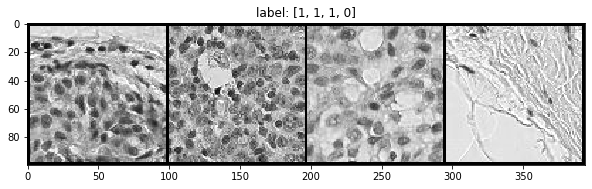

In [33]:
np.random.seed(0)


def show(img, y, color=False):
    # convert tensor to numpy array
    npimg = img.numpy()
   
    # Convert to H*W*C shape
    npimg_tr=np.transpose(npimg, (1, 2, 0))
    
    if color==False:
        npimg_tr=npimg_tr[:, :, 0]
        plt.imshow(npimg_tr, interpolation='nearest', cmap="gray")
    else:
        # display images
        plt.imshow(npimg_tr, interpolation='nearest')
    plt.title("label: "+str(y))
    
grid_size=4
rnd_inds=np.random.randint(0, len(histo_test), grid_size)
print("image indices:", rnd_inds)

x_grid_test=[histo_test[i][0] for i in range(grid_size)]
y_grid_test=[y_test_pred[i] for i in range(grid_size)]

x_grid_test=utils.make_grid(x_grid_test, nrow=4, padding=2)
print(x_grid_test.shape)

plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_test,y_grid_test)

## Kaggle Submission

First, extract the prediction probabilities from the outputs. Note that we perform the exponential function on the model outputs to convert them into probability values:

In [34]:
print(y_test_out.shape)
cancer_preds = np.exp(y_test_out[:, 1])
print(cancer_preds.shape)

(57458, 2)
(57458,)


Next, convert the prediction probabilities into a DataFrame and store them as a CSV file:

In [41]:
# get test id's from the sample_submission.csv 
path2sampleSub = "./data/"+ "sample_submission.csv"

# read sample submission
sample_df = pd.read_csv(path2sampleSub)

# get id column
ids_list = list(sample_df.id)

# convert predictions to to list
pred_list = [p for p in cancer_preds]

# create a dict of id and prediction
pred_dic = dict((key[:-4], value) for (key, value) in zip(histo_test.filenames, pred_list))    


# re-order predictions to match sample submission csv 
pred_list_sub = [pred_dic[id_] for id_ in ids_list]

# create convert to data frame
submission_df = pd.DataFrame({'id':ids_list,'label':pred_list_sub})

# Export to csv
if not os.path.exists("./submissions/"):
    os.makedirs("submissions/")
    print("submission folder created!")
    
path2submission="./submissions/submission.csv"
submission_df.to_csv(path2submission, header=True, index=False)
submission_df.head()

submission folder created!


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.020257
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.345728
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.001162
3,2c35657e312966e9294eac6841726ff3a748febf,0.032256
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.128556


In [47]:
# submit the file to kaggle
!kaggle competitions submit histopathologic-cancer-detection -f "submission.csv" -m 'Yeah! I submit my file through the Google Colab!'

100% 3.34M/3.34M [00:02<00:00, 1.45MB/s]
Successfully submitted to Histopathologic Cancer Detection